In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
warnings.filterwarnings("ignore")


c:\Users\Cristian\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Download of Historical Data

In [2]:
# The Bitcoin ticker is determined
ticker = "BTC-USD"

# we download the data from the 3 previous years
btc_data_1 = yf.download(ticker, period="3y", interval="1d")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
btc_data_1.reset_index(inplace=True)


In [4]:
btc_data_1.head()

Price,Date,Close,High,Low,Open,Volume
Ticker,,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
0,2022-02-17,40538.011719,44132.972656,40249.371094,43937.070312,26246662813
1,2022-02-18,40030.976562,40929.152344,39637.617188,40552.132812,23310007704
2,2022-02-19,40122.156250,40418.878906,39713.058594,40026.023438,13736557863
3,2022-02-20,38431.378906,40119.890625,38112.812500,40118.101562,18340576452
4,2022-02-21,37075.281250,39394.437500,36950.476562,38423.210938,29280402798


Let's make some transformations in the columns.

In [5]:
btc_data_1.columns

MultiIndex([(  'Date',        ''),
            ( 'Close', 'BTC-USD'),
            (  'High', 'BTC-USD'),
            (   'Low', 'BTC-USD'),
            (  'Open', 'BTC-USD'),
            ('Volume', 'BTC-USD')],
           names=['Price', 'Ticker'])

In [6]:
btc_data_1.columns = btc_data_1.columns.get_level_values(0)  # Extrae solo el primer nivel del MultiIndex


In [7]:
btc_data_1 = btc_data_1.loc[:, ~btc_data_1.columns.str.contains('level_0|index|y')]


In [8]:
print(btc_data_1.columns)



Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')


In [9]:
btc_data_1.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in btc_data_1.columns]


In [10]:
print(btc_data_1.columns)


Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')


### Series Visualization

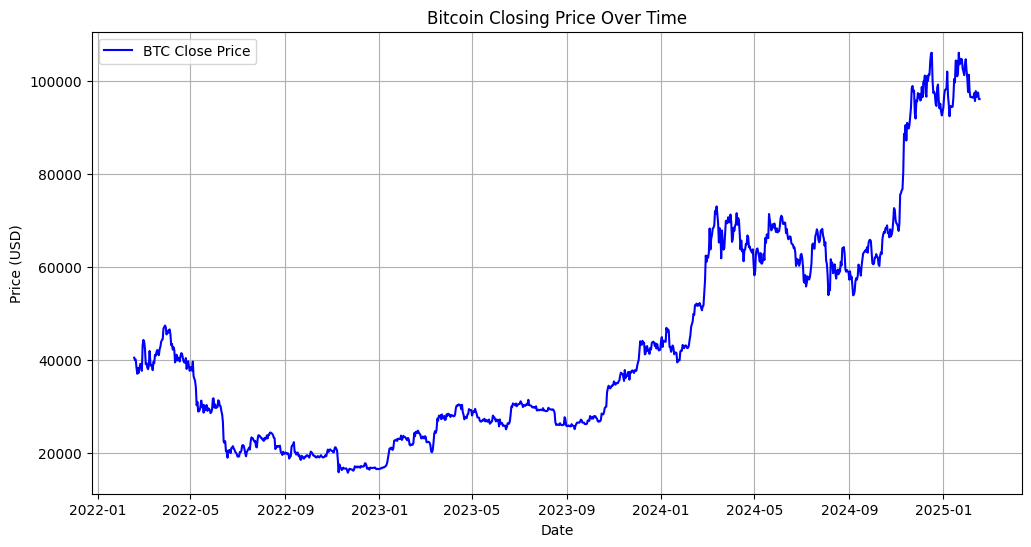

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(btc_data_1['Date'], btc_data_1['Close'], label="BTC Close Price", color="blue")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Closing Price Over Time")
plt.legend()
plt.grid()
plt.show()


Let's create a new column which shows the growth percentage.

In [12]:
btc_data_1["daily_return"] = btc_data_1["Close"].pct_change()


In [13]:
btc_data_1.head()

,Date,Close,High,Low,Open,Volume,daily_return
0,2022-02-17,40538.011719,44132.972656,40249.371094,43937.070312,26246662813,NaN
1,2022-02-18,40030.976562,40929.152344,39637.617188,40552.132812,23310007704,-0.012508
2,2022-02-19,40122.156250,40418.878906,39713.058594,40026.023438,13736557863,0.002278
3,2022-02-20,38431.378906,40119.890625,38112.812500,40118.101562,18340576452,-0.042141
4,2022-02-21,37075.281250,39394.437500,36950.476562,38423.210938,29280402798,-0.035286


In [14]:
btc_data_1["Date"] = pd.to_datetime(btc_data_1["Date"])


In [15]:
btc_data_1.sort_values("Date", inplace=True)


Checking null values

In [16]:
print(btc_data_1.isnull().sum())


Date            0
Close           0
High            0
Low             0
Open            0
Volume          0
daily_return    1
dtype: int64


In [17]:
btc_data_1.head()

,Date,Close,High,Low,Open,Volume,daily_return
0,2022-02-17,40538.011719,44132.972656,40249.371094,43937.070312,26246662813,NaN
1,2022-02-18,40030.976562,40929.152344,39637.617188,40552.132812,23310007704,-0.012508
2,2022-02-19,40122.156250,40418.878906,39713.058594,40026.023438,13736557863,0.002278
3,2022-02-20,38431.378906,40119.890625,38112.812500,40118.101562,18340576452,-0.042141
4,2022-02-21,37075.281250,39394.437500,36950.476562,38423.210938,29280402798,-0.035286


Let's calculate the SMA for short and medium term.

In [18]:
btc_data_1["SMA_7"] = btc_data_1["Close"].rolling(window=7).mean()
btc_data_1["SMA_30"] = btc_data_1["Close"].rolling(window=30).mean()


Volatility too.

In [19]:
btc_data_1["volatility_7"] = btc_data_1["daily_return"].rolling(window=7).std()


In [20]:
btc_data_1.head(15)

,Date,Close,High,Low,Open,Volume,daily_return,SMA_7,SMA_30,volatility_7
0,2022-02-17,40538.011719,44132.972656,40249.371094,43937.070312,26246662813,NaN,NaN,NaN,NaN
1,2022-02-18,40030.976562,40929.152344,39637.617188,40552.132812,23310007704,-0.012508,NaN,NaN,NaN
2,2022-02-19,40122.156250,40418.878906,39713.058594,40026.023438,13736557863,0.002278,NaN,NaN,NaN
3,2022-02-20,38431.378906,40119.890625,38112.812500,40118.101562,18340576452,-0.042141,NaN,NaN,NaN
4,2022-02-21,37075.281250,39394.437500,36950.476562,38423.210938,29280402798,-0.035286,NaN,NaN,NaN
5,2022-02-22,38286.027344,38359.855469,36488.933594,37068.769531,25493150450,0.032656,NaN,NaN,NaN
6,2022-02-23,37296.570312,39122.394531,37201.816406,38285.281250,21849073843,-0.025844,38825.771763,NaN,NaN
7,2022-02-24,38332.609375,38968.839844,34459.218750,37278.566406,46383802093,0.027778,38510.714286,NaN,0.029682
8,2022-02-25,39214.218750,39630.324219,38111.343750,38333.746094,26545599159,0.022999,38394.034598,NaN,0.031668
9,2022-02-26,39105.148438,40005.347656,38702.535156,39213.082031,17467554129,-0.002781,38248.747768,NaN,0.031598


# Data Visualization

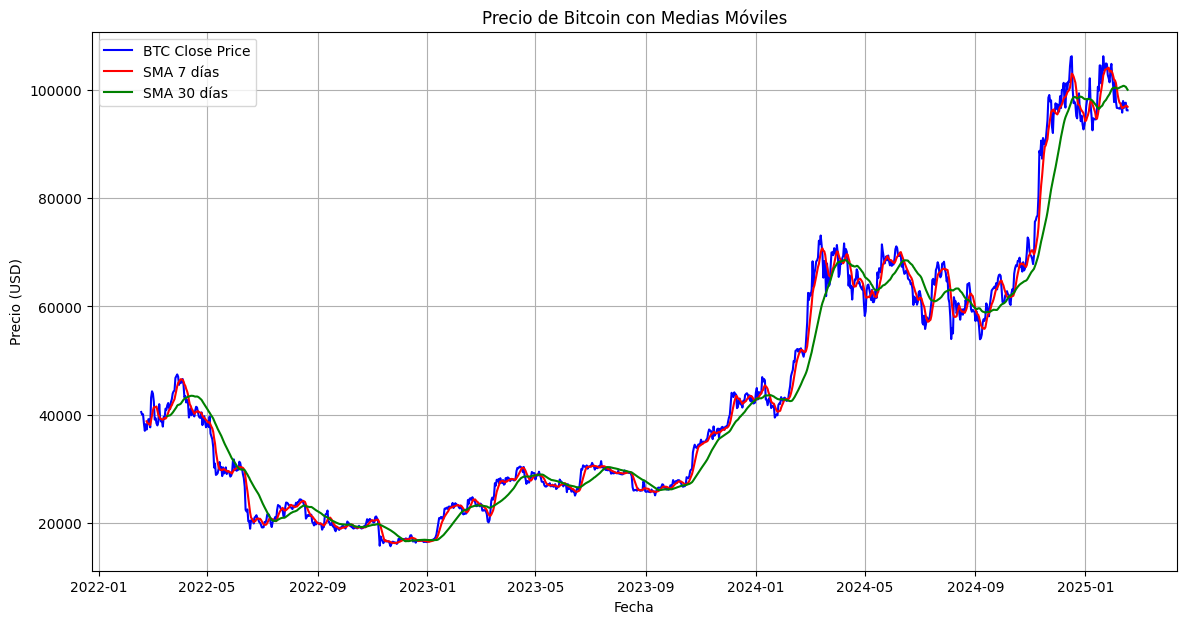

In [21]:
plt.figure(figsize=(14, 7))
plt.plot(btc_data_1["Date"], btc_data_1["Close"], label="BTC Close Price", color="blue")
plt.plot(btc_data_1["Date"], btc_data_1["SMA_7"], label="SMA 7 días", color="red")
plt.plot(btc_data_1["Date"], btc_data_1["SMA_30"], label="SMA 30 días", color="green")
plt.xlabel("Fecha")
plt.ylabel("Precio (USD)")
plt.title("Precio de Bitcoin con Medias Móviles")
plt.legend()
plt.grid()
plt.show()


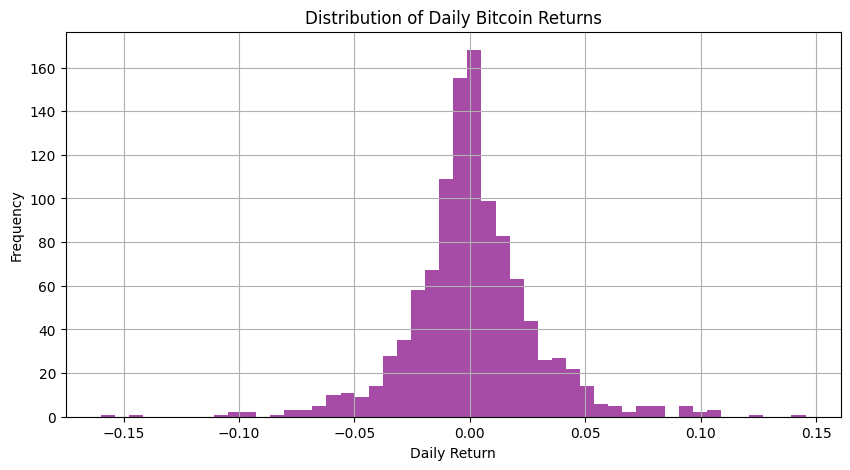

In [22]:
plt.figure(figsize=(10, 5))
plt.hist(btc_data_1["daily_return"], bins=50, color="purple", alpha=0.7)
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.title("Distribution of Daily Bitcoin Returns")
plt.grid()
plt.show()


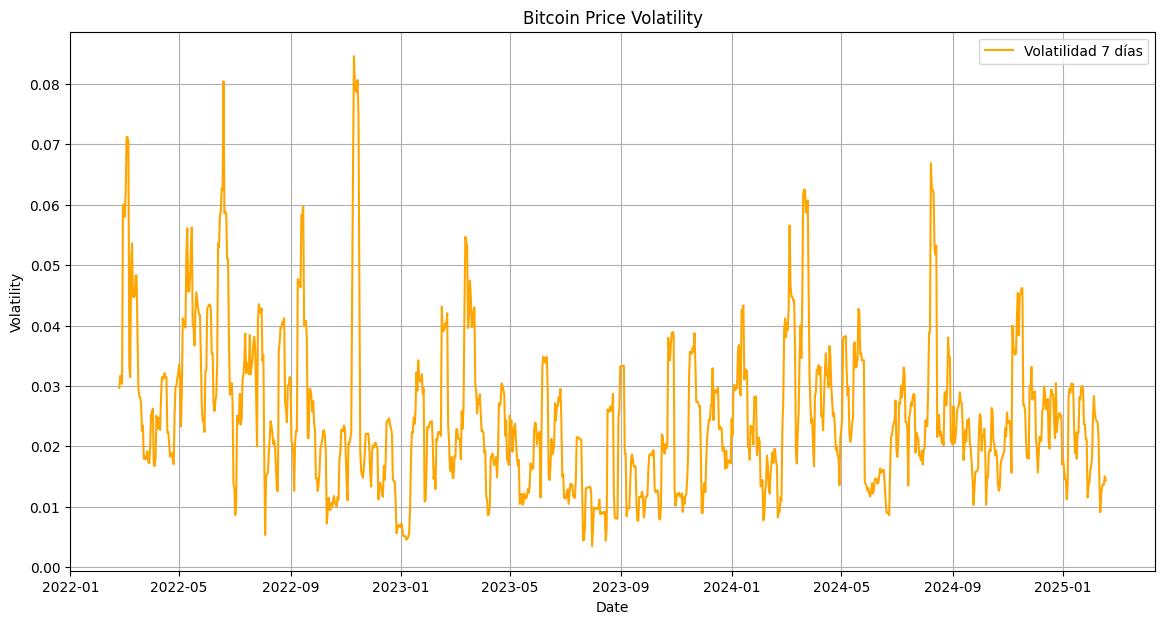

In [23]:
plt.figure(figsize=(14, 7))
plt.plot(btc_data_1["Date"], btc_data_1["volatility_7"], label="Volatilidad 7 días", color="orange")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Bitcoin Price Volatility")
plt.legend()
plt.grid()
plt.show()


# Machine Learning Model

In [24]:
# Rename columns for propeht model
btc_prophet = btc_data_1.rename(columns={"Date": "ds", "Close": "y"})  

# Creation of Prophet model
model = Prophet()
model.fit(btc_prophet)


17:35:46 - cmdstanpy - INFO - Chain [1] start processing
17:35:49 - cmdstanpy - INFO - Chain [1] done processing


In [25]:
# We make a df with future predictions
future = model.make_future_dataframe(periods=90)

# Prediction done
forecast = model.predict(future)

# First values
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()


,ds,yhat,yhat_lower,yhat_upper
1182,2025-05-14,124739.132649,119098.386380,130613.949100
1183,2025-05-15,124739.006902,118351.983241,130848.391875
1184,2025-05-16,124904.473197,119416.523138,130582.660473
1185,2025-05-17,124965.072609,119068.710511,130490.625751
1186,2025-05-18,125056.897381,119368.485222,130914.057151


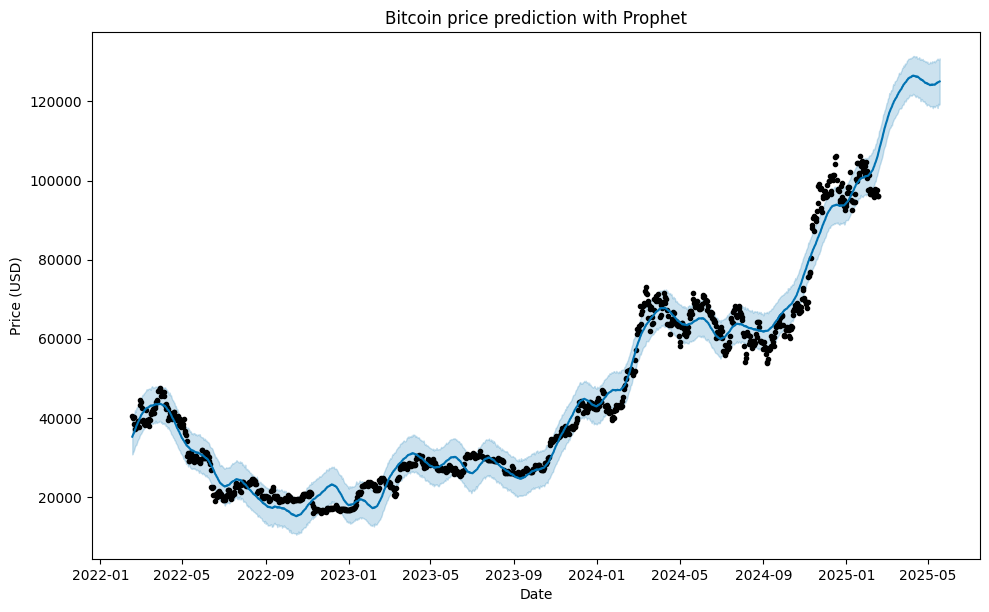

In [26]:
# Real data and predictions graph
fig = model.plot(forecast)
plt.title("Bitcoin price prediction with Prophet")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid()
plt.show()


# Prohpet with Hyperparameters 

17:35:52 - cmdstanpy - INFO - Chain [1] start processing
17:35:52 - cmdstanpy - INFO - Chain [1] done processing


MAE: 9637.326637695336
RMSE: 12637.235990821739
MAPE: 10.828319362178444%


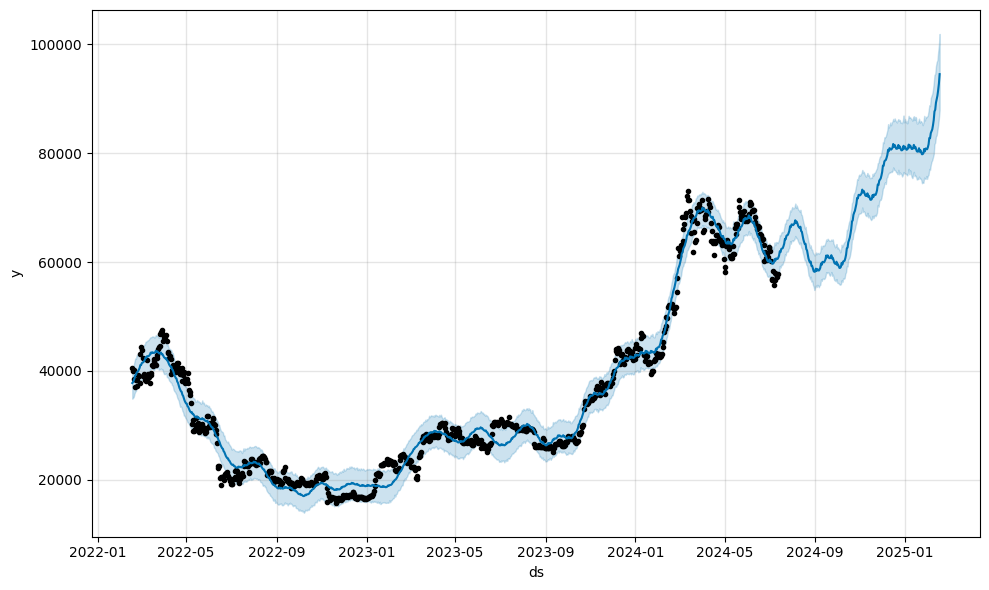

In [27]:
# We split the data for training and test
train_size = int(len(btc_prophet) * 0.8)
train = btc_prophet.iloc[:train_size]
test = btc_prophet.iloc[train_size:]

# Hyperparameters
model = Prophet(
    changepoint_prior_scale=0.05,  
    seasonality_mode='multiplicative',  
    weekly_seasonality=True,
    daily_seasonality=False
)


model.fit(train)
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

# Model Evaluation 
y_true = test['y'].values
y_pred = forecast['yhat'].iloc[train_size:].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")

model.plot(forecast);


# Hyperparameters tuning

17:35:54 - cmdstanpy - INFO - Chain [1] start processing
17:35:54 - cmdstanpy - INFO - Chain [1] done processing
17:35:55 - cmdstanpy - INFO - Chain [1] start processing
17:35:55 - cmdstanpy - INFO - Chain [1] done processing
17:35:56 - cmdstanpy - INFO - Chain [1] start processing
17:35:57 - cmdstanpy - INFO - Chain [1] done processing
17:35:57 - cmdstanpy - INFO - Chain [1] start processing
17:35:58 - cmdstanpy - INFO - Chain [1] done processing
17:35:59 - cmdstanpy - INFO - Chain [1] start processing
17:35:59 - cmdstanpy - INFO - Chain [1] done processing
17:36:02 - cmdstanpy - INFO - Chain [1] start processing
17:36:04 - cmdstanpy - INFO - Chain [1] done processing
17:36:05 - cmdstanpy - INFO - Chain [1] start processing
17:36:06 - cmdstanpy - INFO - Chain [1] done processing
17:36:07 - cmdstanpy - INFO - Chain [1] start processing
17:36:07 - cmdstanpy - INFO - Chain [1] done processing
17:36:08 - cmdstanpy - INFO - Chain [1] start processing
17:36:09 - cmdstanpy - INFO - Chain [1]

Best hyperparameters: (0.05, 'additive', True, True)
Best RMSE: 11342.601603070183


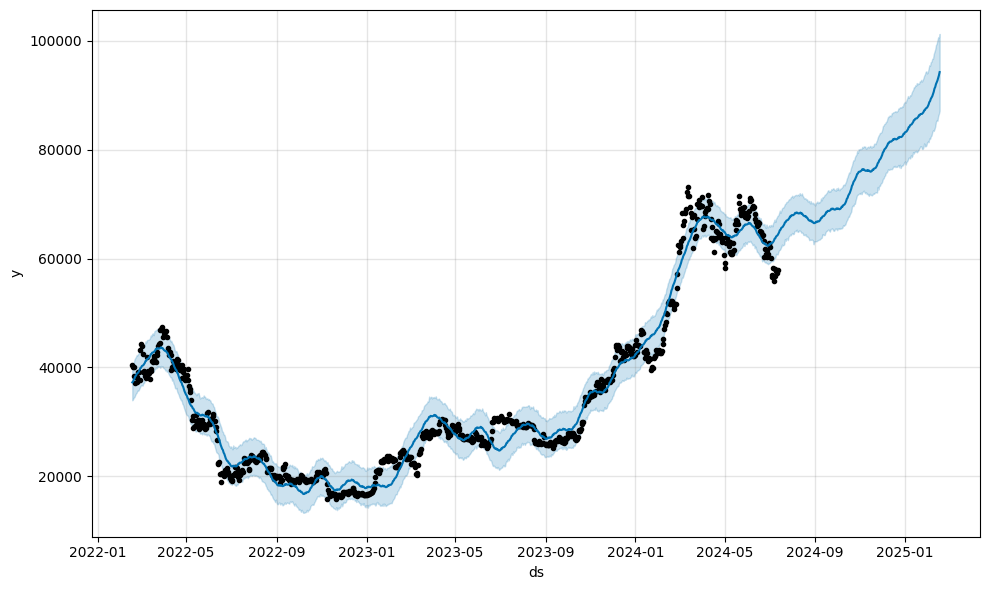

In [28]:
train_size = int(len(btc_prophet) * 0.8)
train = btc_prophet.iloc[:train_size]
test = btc_prophet.iloc[train_size:]

# We define the search set for hyperparameters tuning
param_grid = {
    'changepoint_prior_scale': [0.01, 0.05, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative'],
    'weekly_seasonality': [True, False],
    'daily_seasonality': [True, False]
}

# Combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))

# Results storage
best_params = None
best_rmse = float("inf")

for params in param_combinations:
    
    model = Prophet(
        changepoint_prior_scale=params[0],
        seasonality_mode=params[1],
        weekly_seasonality=params[2],
        daily_seasonality=params[3]
    )
    
    # Training
    model.fit(train)
    
    # Predictions
    future = model.make_future_dataframe(periods=len(test))
    forecast = model.predict(future)
    
    # Evaluation
    y_true = test['y'].values
    y_pred = forecast['yhat'].iloc[train_size:].values

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # Saving best model
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params
        best_forecast = forecast

print(f"Best hyperparameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

# New Model
model.plot(best_forecast);


In [30]:
best_params = {
    "changepoint_prior_scale": 0.05,  
    "daily_seasonality": False,
    "weekly_seasonality": True
}

best_model = Prophet(
    changepoint_prior_scale=best_params["changepoint_prior_scale"],
    #seasonality_mode=best_params["seasonality_mode"],
    daily_seasonality=best_params["daily_seasonality"],
    weekly_seasonality=best_params["weekly_seasonality"]
)

best_model.fit(btc_prophet)  

one_year = 365
two_years = 2 * 365

future_1y = best_model.make_future_dataframe(periods=one_year)
future_2y = best_model.make_future_dataframe(periods=two_years)


forecast_1y = best_model.predict(future_1y)
forecast_2y = best_model.predict(future_2y)


df_forecast_1y = forecast_1y[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
df_forecast_2y = forecast_2y[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]


print("Predictions for 1 year:")
print(df_forecast_1y.tail())

print("\nPredictions for 2 years:")
print(df_forecast_2y.tail())

df_forecast_1y.to_csv("prediccion_1_ano.csv", index=False)
df_forecast_2y.to_csv("prediccion_2_anos.csv", index=False)


17:37:38 - cmdstanpy - INFO - Chain [1] start processing
17:37:40 - cmdstanpy - INFO - Chain [1] done processing


Predictions for 1 year:
             ds           yhat     yhat_lower     yhat_upper
1457 2026-02-13  169580.296105  140530.814414  199175.860072
1458 2026-02-14  170025.014104  139934.102890  200944.869969
1459 2026-02-15  170524.589087  140238.982766  200429.558291
1460 2026-02-16  171275.697928  141031.569623  201455.973534
1461 2026-02-17  171831.608887  141298.435110  202115.105632

Predictions for 2 years:
             ds           yhat     yhat_lower     yhat_upper
1822 2027-02-13  234402.417690  140258.903107  331330.545395
1823 2027-02-14  234858.797389  141254.828658  331336.368264
1824 2027-02-15  235570.816822  139362.992356  333372.443140
1825 2027-02-16  236092.343380  140816.844365  331977.270316
1826 2027-02-17  236842.509363  142634.386799  333479.659862


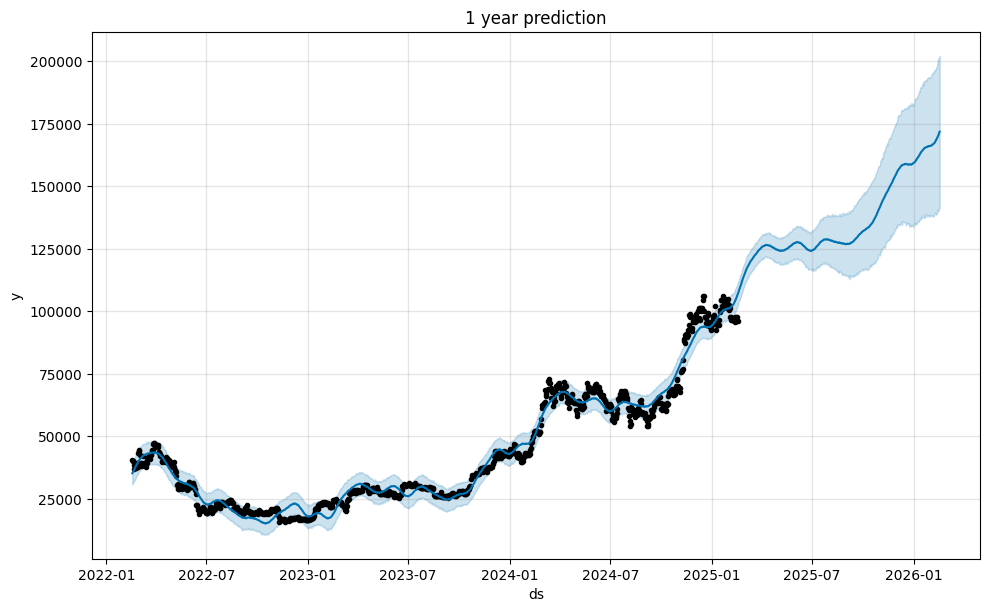

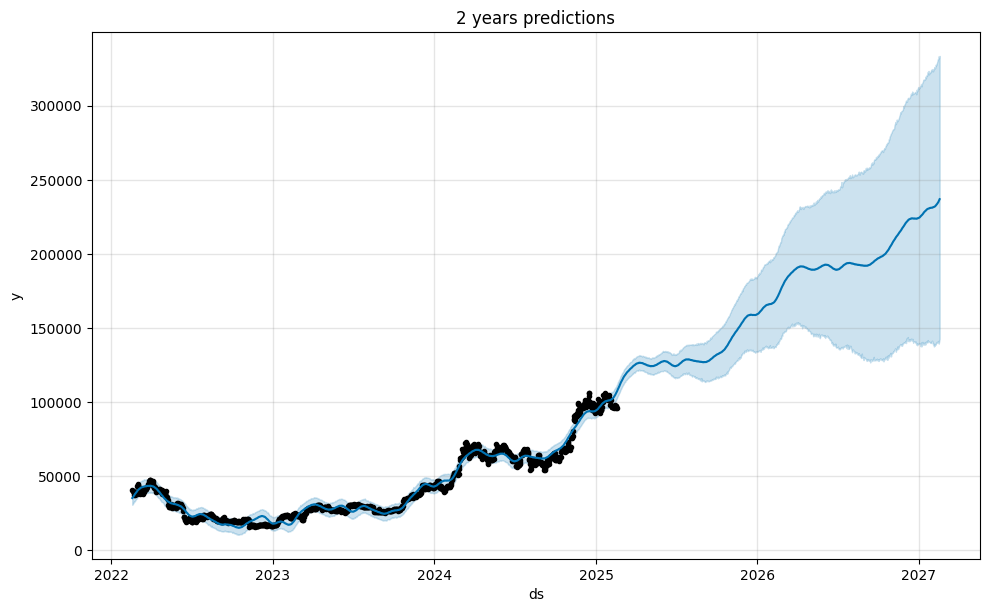

In [31]:
# 1 year prediction
fig1 = best_model.plot(forecast_1y)
plt.title("1 year prediction")
plt.show()

# 1 year prediction
fig2 = best_model.plot(forecast_2y)
plt.title("2 years predictions")
plt.show()


In [ ]:
joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']